# DigitalTWINS on FHIR - workflow report for all EPs

## Installation


In [ ]:
pip install digitaltwins-on-fhir

## Example - Generating workflow report for EP4
### Connect to fhir server

In [ ]:
from digitaltwins_on_fhir import Adapter
adapter = Adapter("http://130.216.217.173:8080/fhir")
client = adapter.async_client

### Generate DiagnosticReport for the patient
Let's assume we want to generate a report for the patient in a breast research dataset, and running breast workflow / workflow tools.

- patient uuid: `54f2abff-6594-11ef-917d-484d7e9beb16`
- workflow uuid: `e3b3eaa0-65ae-11ef-917d-484d7e9beb16`
- workflow_tool uuid: `b6b7b363-65ae-11ef-917d-484d7e9beb16`
- dataset uuid: `93d49efa-5f4e-11ef-917d-484d7e9beb16`

In [ ]:
# find the patient
patient = await adapter.search().search_resource_async('Patient', "54f2abff-6594-11ef-917d-484d7e9beb16")
patient

In [ ]:
# Find the workflow
workflow = await adapter.search().search_resource_async("PlanDefinition", "e3b3eaa0-65ae-11ef-917d-484d7e9beb16")
workflow

In [ ]:
# Find the generate report workflow tool
workflow_tool = await adapter.search().search_resource_async("ActivityDefinition", "b6b7b363-65ae-11ef-917d-484d7e9beb16")
workflow_tool

In [ ]:
# Find the dataset
dataset = await adapter.search().search_resource_async("ResearchStudy", "93d49efa-5f4e-11ef-917d-484d7e9beb16")
dataset

Then we need to find out the workflow tool process for this patient

In [ ]:
research_subject = await client.resources("ResearchSubject").search(patient=patient.to_reference(),
                                                                    study=dataset.to_reference()).first()
processes = await client.resources("Task").search(owner=patient.to_reference(),
                                                  subject=workflow.to_reference(),
                                                  focus=workflow_tool.to_reference(),
                                                  based_on=research_subject.to_reference()).fetch_all()
report_process = processes[0]
report_process

Now we can based on the workflow tool process to generate the DignosticReport

In [ ]:
from digitaltwins_on_fhir.core.resource import CodeableConcept, Coding, Code, Reference, Identifier, DiagnosticReport

In [ ]:
obs = []
for item in report_process.get("output"):
    if item.get("type").get("text") == "Observation":
        ob = await item.get("valueReference").to_resource()
        obs.append(
            Reference(reference=item.get("valueReference").reference, display=ob.get("code").get("text")))

report = DiagnosticReport(status="final",
                          identifier=[
                              Identifier(use=Code("official"), system="sparc.org",
                                          value='sparc-breast-workflow-report-xxx-001')],
                          code=CodeableConcept(codings=[Coding(system="https://www.auckland.ac.nz/en/abi.html",
                                                                code=Code(value="Workflow report"),
                                                                display="Workflow report")],
                                                text="Workflow report"),
                          subject=patient.to_reference(),
                          result=obs,
                          conclusion="This is a report for breast")
process = adapter.digital_twin().process()
r = await process.generate_diagnostic_report(report)
r

Now we can use third-party package to generate final pdf report for the patient

The PDF code below will be merge to digitaltwins-on-fhir later

In [ ]:
pip install fpdf

In [ ]:
from fpdf import FPDF
class PDF(FPDF):

    def set_title(self, title):
        self.title = title

    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, self.title, 0, 1, 'C')

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

In [ ]:
pdf = PDF('P', 'mm', 'A4')
pdf.set_title("Breast workflow report")
pdf.add_page()
pdf.set_font('Arial', '', 10)
pdf.cell(0, 10, f'Patient uuid: {patient.get_by_path(["identifier", 0, "value"])}', 0, 1, 'L')
pdf.cell(0, 10, f'Workflow: {workflow.get("title")}, uuid: {workflow.get_by_path(["identifier", 0, "value"])}', 0, 1, 'L')
pdf.multi_cell(0, 10, f'Workflow description: {workflow.get("description")}', 0, 1, 'L')
pdf.cell(0, 10, f'Execute time: {report_process.get("lastModified")}', 0, 1, 'L')
pdf.cell(0, 10, f'Results:', 0, 1, 'L')
for result in r.get('result'):
    ob = await result.to_resource()
    pdf.cell(400, 10, f'{ob.get("code").get("text")}: {ob.get("valueQuantity").get("value")} {ob.get("valueQuantity").get("unit")}', 0, 1, 'L')
pdf.output('Breast workflow result.pdf')

If you run the code locally, then you will get a PDF file looks like below image:

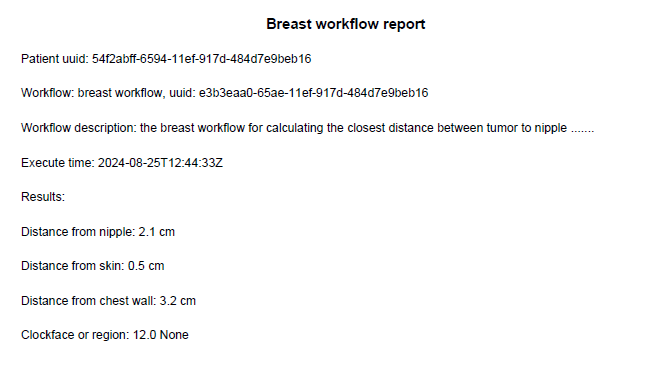